In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/Project A')  # Change the directory to the project folder in your drive

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2
from google.colab.patches import cv2_imshow
from keras.utils.np_utils import to_categorical
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
from sklearn.linear_model import LinearRegression
from tensorflow.python.framework.versions import VERSION as __version__
print(tensorflow.__version__)

2.8.0


# Dataset loader

In [4]:
train_dir = '/content/drive/My Drive/Project A/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/Project A/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4503 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [5]:
# load our pre trained model
model=load_model('/content/drive/My Drive/Project A/models/HMT.h5') # change this to the location of the model in your drive

# Explanation

Load the explaier library

In [6]:
from xai_utils import *

Load a batch of images

In [7]:
test_generator.reset()

In [8]:
image_batch,label_batch=test_generator.next()

# Test results of model


In [9]:
# printing overall accuracy using our test set
results = model.evaluate(test_generator)
print("Overall classification accuracy on test set:", results[1])

16/16 [==============================] - 109s 7s/step - loss: 0.5554 - accuracy: 0.8347
Overall classification accuracy on test set: 0.8346773982048035


In [10]:
#test labels for our test set
test_label = test_generator.labels

In [11]:
# converting test labels to one hot encoded
test_label_o = to_categorical(test_label, num_classes=8)

In [12]:
# Class-wise classification accuracy for all classes
from sklearn.metrics import confusion_matrix

y_pred_o = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_o,axis=1)

matrix = confusion_matrix(y_true = test_label, y_pred = y_pred)
classwise_accuracy_array = matrix.diagonal()/matrix.sum(axis=1)


16/16 [==============================] - 3s 150ms/step


In [13]:
for i in np.unique(test_label):
  print(f'Accuracy for class: {i} is {classwise_accuracy_array[i]}')

Accuracy for class: 0 is 0.8548387096774194
Accuracy for class: 1 is 0.7580645161290323
Accuracy for class: 2 is 0.7741935483870968
Accuracy for class: 3 is 0.8548387096774194
Accuracy for class: 4 is 0.6612903225806451
Accuracy for class: 5 is 0.8225806451612904
Accuracy for class: 6 is 0.9516129032258065
Accuracy for class: 7 is 1.0


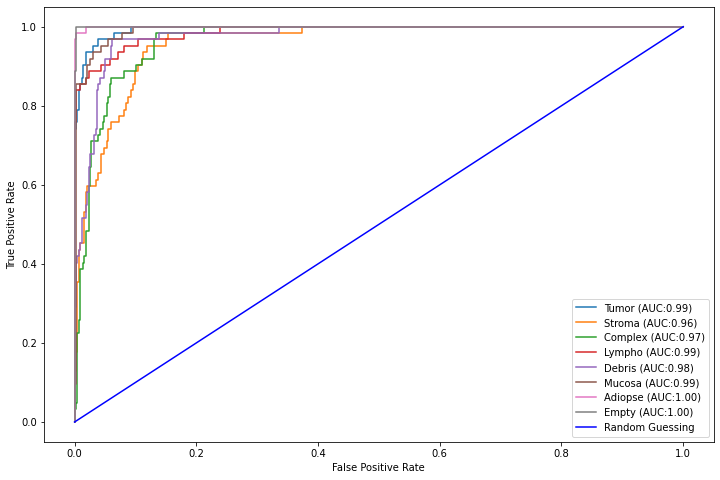

In [14]:
# Plot the classification ROC and AUC curves for each class

classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

for (idx, c_label) in enumerate(classes):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_label_o[:,idx].astype(int), y_pred_o[:,idx])
  c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, sklearn.metrics.auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Text(30.5, 0.5, 'True')

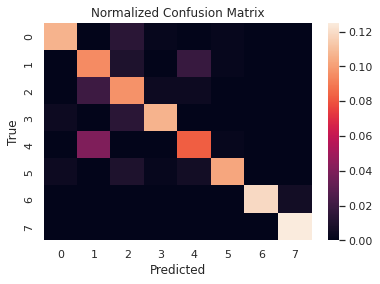

In [15]:
# Plot the normalized confusion matrix
import sklearn


import seaborn as sns
sns.set_theme()

c = sklearn.metrics.confusion_matrix(test_label, y_pred, normalize='all')
ax = sns.heatmap(c)
ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [16]:
# Precision, Recall, and F-1 score on the test set

precision_obj = tf.keras.metrics.Precision()
precision_obj.update_state(test_label_o, y_pred_o)
precision = precision_obj.result().numpy()


recall_obj = tf.keras.metrics.Recall()
recall_obj.update_state(test_label_o, y_pred_o)
recall = recall_obj.result().numpy()


f1_score = 2*(precision*recall)/(recall+precision)

print('Precision: ',precision)
print('Recall: ',recall)
print('F1_score: ',f1_score)

Precision:  0.8648069
Recall:  0.8125
F1_score:  0.8378378666507466


# Preconditions for mapping

Classes:

In [17]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [18]:
#setting a random seed to easily recreate outputs
np.random.seed(222)

In [19]:
#choosing the index of the image we will work with in the image batch
index=16

In [20]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9097161


# Generate explanation map

## LIME


In [21]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Make a function to generate a lime mask

In [22]:
def Calc_lime_mask(model, image_batch, index, num_p=150, num_feature=10):
  np.random.seed(222)
  new_image=np.array(image_batch[index], dtype=np.double)
  superpixels = skimage.segmentation.quickshift(new_image, kernel_size=4,max_dist=200, ratio=0.2)
  num_superpixels = np.unique(superpixels).shape[0]

  num_perturb = num_p
  perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

  predictions = []

  for pert in perturbations:
    perturbed_img = perturb_image(new_image,pert,superpixels)
    perturb_image_batch= copy.deepcopy(image_batch)
    perturb_image_batch[index]=perturbed_img
    pred = model.predict(perturb_image_batch)
    predictions.append(pred[index])

  predictions = np.array(predictions)
  predictions_new=predictions[:,np.newaxis,:]

  original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
  distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

  kernel_width = 0.25
  weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

  class_to_explain = np.argmax(prediction[index])
  simpler_model = LinearRegression()
  simpler_model.fit(X=perturbations, y=predictions_new[:,:,class_to_explain], sample_weight=weights)
  coeff = simpler_model.coef_[0]

  num_top_features = num_feature
  top_features = np.argsort(coeff)[-num_top_features:] 

  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels

  mask_new=perturb_image(new_image,mask,superpixels)
  Lime_mask=np.mean(mask_new,axis=2)
  Lime_mask[Lime_mask>0]=1

  return(Lime_mask)

In [23]:
%%time
New_Lime_Mask=Calc_lime_mask(model,image_batch,index,150,6)

CPU times: user 21.1 s, sys: 632 ms, total: 21.7 s
Wall time: 22.1 s


## Grad-CAM (Gradient-based Class Activation Mapping)

In [24]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 740 ms, sys: 45.3 ms, total: 785 ms
Wall time: 1.3 s


## Saliency Map- Vanilla gradient


In [25]:
class SaliencyMap():
    def __init__(self, model):
        """Constructs a Vanilla Gradient Map by computing dy/dx.
        Args:
            model: The TensorFlow model used to evaluate Gradient Map.
                model takes image as input and outputs probabilities vector.
        """
        self.model = model


    def get_top_predicted_idx(self, image_batch,index):
        """Outputs top predicted class for the input image.
        Args:
            img_processed: numpy image array in NHWC format, pre-processed according
                to the defined model standard.
        Returns:
            Index of the top predicted class for the input image.
        """
        preds = self.model.predict(image_batch)
        top_pred_idx = tf.argmax(preds,axis=1)
        return top_pred_idx


    def get_gradients(self, image_batch, index):
        """Computes the gradients of outputs w.r.t input image.
        Args:
            image: numpy image array in NHWC format, pre-processed according
                to the defined model standard.
        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        image_batch = tf.convert_to_tensor(image_batch)
        top_pred_idx = self.get_top_predicted_idx(image_batch,index)

        with tf.GradientTape() as tape:
            tape.watch(image_batch)
            preds = self.model(image_batch)
            top_class = preds[:,top_pred_idx[index]]

        grads = tape.gradient(top_class, image_batch)
        return grads


    def norm_grad(self, grad_x):
        """Normalizes gradient to the range between 0 and 1
        (for visualization purposes).
        Args:
            grad_x: numpy gradients array.
        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        abs_grads = np.abs(grad_x)
        grad_max_ = np.max(abs_grads, axis=3)[0]
        arr_min, arr_max  = np.min(grad_max_), np.max(grad_max_)
        normalized_grad = (grad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
        normalized_grad = normalized_grad.reshape(1,grad_x.shape[1],grad_x.shape[2],1)

        return normalized_grad


    def get_mask(self, image, tensor_format=False):
        """Returns a saliency mask specific to each method.
        Args:
            image: input image in NHWC format, not batched.
        """
        raise NotImplementedError('A derived class should implement get_mask()')

Make Saliency Map function

In [26]:
def Calc_Saliency(model, image_batch, index):
  S=SaliencyMap(model)
  mask=S.get_gradients(image_batch,index)
  mask=mask[index].numpy()
  mask=np.abs(mask)
  m=mask.sum(axis=-1)
  m=m+np.abs(m.min())
  m -= m.min()
  m /= m.max()+10e-30
  return (m)

In [27]:
%%time
sal_map=Calc_Saliency(model,image_batch,index)

CPU times: user 1.53 s, sys: 14.6 ms, total: 1.55 s
Wall time: 1.55 s


# Plot the results

Text(0.5, 1.0, 'Explanation map (Grad-CAM)')

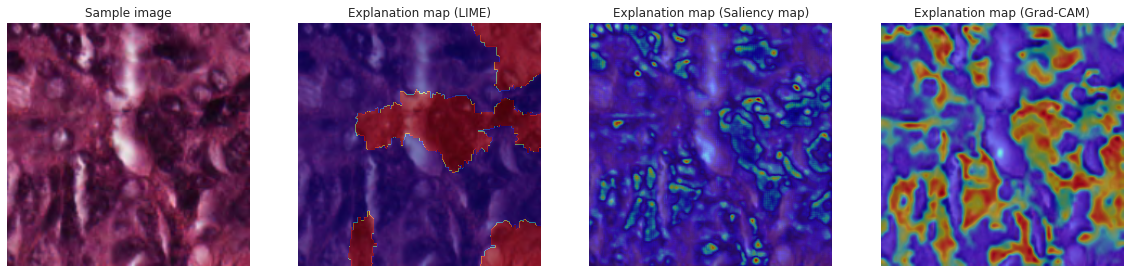

In [28]:

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(New_Lime_Mask, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (LIME)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(sal_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Saliency map)')


plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

# Quantitative evaluation of the explanation algorithm

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
# calculate drop and increase % for GradCAM and saliency map using vanilla gradient
test_generator.reset()
drop_rate_GCAM = 0.
drop_rate_Sal = 0.

Inc_rate_GCAM=0.
Inc_rate_Sal=0.

for _ in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    for index in range(32):
        
        explanation_map_GCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        drop_values= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GCAM, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate_GCAM+= drop_values[0]
        if drop_values[1]:
          Inc_rate_GCAM+=1

        explanation_map_Sal = Calc_Saliency(model,image_batch,index)
        drop_values= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Sal, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate_Sal+= drop_values[0]
        if drop_values[1]:
          Inc_rate_Sal+=1

drop_rate_GCAM /= (15*32)
Inc_rate_GCAM /= (15*32)

drop_rate_Sal /= (15*32)
Inc_rate_Sal /= (15*32)

In [ ]:
# calculate drop and increase % for LIME
drop_rate_Lime = 0.
Inc_rate_Lime=0.
test_generator.reset()
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    prediction=model(image_batch)
    for index in range(32):

        explanation_map_Lime = Calc_lime_mask(model,image_batch,index,25,4)
        drop_values= calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Lime, class_index=np.argmax(prediction[index]), frac=0.9)
        drop_rate_Lime+= drop_values[0]
        if drop_values[1]:
          Inc_rate_Lime+=1

drop_rate_Lime /= (15*32)
Inc_rate_Lime /= (15*32)


In [ ]:
print('GCAM drop rate:',drop_rate_GCAM)
print('GCAM Inc rate:',Inc_rate_GCAM)
print('Sal drop rate:',drop_rate_Sal)
print('Sal Inc rate:',Inc_rate_Sal)

GCAM drop rate: 0.4893204470118866
GCAM Inc rate: 0.29583333333333334
Sal drop rate: 0.5948694330660836
Sal Inc rate: 0.2375


In [ ]:
print('Lime drop rate:',drop_rate_Lime)
print('Lime Inc rate:',Inc_rate_Lime)

NameError: ignored